In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd
import os
import pandas as pd
import json

from scipy import signal 

import glob

from DataManager import ParticipantData, MeasurementData
from Helpers import read_normalized_json_to_df, save_to_disk, load_from_disk, create_rolling_windows 

In [2]:
data_path = './data/'

reference_data_all_failed_save_path = "./post_recorded_reference_data/reference_dict_all.pickle"
REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(reference_data_all_failed_save_path)

correlation_dict_path = "./post_recorded_reference_data/corr_dict.pickle"
CORRELATION_DICT = load_from_disk(correlation_dict_path)

In [3]:
print(REFERENCE_DATA_ALL_EVENTS_FAILED["Westbrueck"][0].columns)

Index(['CarPosition.x', 'CarPosition.y', 'CarPosition.z',
       'car_rotation_angles.x', 'car_rotation_angles.y',
       'car_rotation_angles.z', 'car_rotation_direction.x',
       'car_rotation_direction.y', 'car_rotation_direction.z'],
      dtype='object')


# Load data

In [4]:

participant_id = os.path.basename(glob.glob("./data/EyeTracking/*.txt")[0]).split("_")[0]
eyes = glob.glob("./data/EyeTracking/" + str(participant_id) + "*.txt")
inputs = glob.glob("./data/Input/" + str(participant_id) + "*.txt")
calib = glob.glob("./data/ParticipantCalibrationData/" + str(participant_id) + "*.txt")[0]
scenes = glob.glob("./data/SceneData/" + str(participant_id) + "*.txt")

eyes_paths  = ["./data/EyeTracking/"]
input_paths = ["./data/Input/"]
calib_paths = ["./data/ParticipantCalibrationData/"]
scene_paths = ["./data/SceneData/"]

'''
print(eyes)
print(inputs)
print(calib)
print(scenes)
'''

#participant1 = ParticipantData(eyes, inputs, calib, scenes, True, True)

measurement1 = MeasurementData(eyes_paths,input_paths,calib_paths,scene_paths,True)


MeasurementData: Found files for participant 0bc17d704fec4a9eb892d905fc2e5da9.
Input data files: ['./data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Autobahn.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Westbrueck.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_TrainingScene.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_MountainRoad.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_CountryRoad.txt']
Eyetracking data files: ['./data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_MountainRoad.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Westbrueck.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_TrainingScene.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Autobahn.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_CountryRoad.txt']
Calibration data files: ['./data/ParticipantCalibrationData/0bc17d704fec4a9eb892d905fc2e5da9_ParticipantCalib

# Load Reference and Correlation Data

In [5]:
measurement1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants...
ParticipantData: Applying reference data to back of Westbrueck's segment 0. Number of datapoints used: 2089.
Creating relative directions considering roll.


100%|██████████| 2089/2089 [00:00<00:00, 5674.84it/s]


Creating relative directions considering roll.


100%|██████████| 2089/2089 [00:00<00:00, 5926.66it/s]


ParticipantData: Applying reference data to back of Westbrueck's segment 1. Number of datapoints used: 2131.
Creating relative directions considering roll.


100%|██████████| 2131/2131 [00:00<00:00, 5740.27it/s]


Creating relative directions considering roll.


100%|██████████| 2131/2131 [00:00<00:00, 5767.67it/s]


ParticipantData: Applying reference data to back of Westbrueck's segment 2. Number of datapoints used: 1932.
Creating relative directions considering roll.


100%|██████████| 1932/1932 [00:00<00:00, 3513.64it/s]


Creating relative directions considering roll.


100%|██████████| 1932/1932 [00:00<00:00, 5914.55it/s]


ParticipantData: Applying reference data to back of Westbrueck's segment 3. Number of datapoints used: 1767.
Creating relative directions considering roll.


100%|██████████| 1767/1767 [00:00<00:00, 5759.57it/s]


Creating relative directions considering roll.


100%|██████████| 1767/1767 [00:00<00:00, 5688.18it/s]


ParticipantData: Applying reference data to back of MountainRoad's segment 0. Number of datapoints used: 1691.
Creating relative directions considering roll.


100%|██████████| 1691/1691 [00:00<00:00, 5647.76it/s]


Creating relative directions considering roll.


100%|██████████| 1691/1691 [00:00<00:00, 5784.94it/s]


ParticipantData: Applying reference data to back of MountainRoad's segment 1. Number of datapoints used: 3131.
Creating relative directions considering roll.


100%|██████████| 3131/3131 [00:00<00:00, 5815.68it/s]


Creating relative directions considering roll.


100%|██████████| 3131/3131 [00:00<00:00, 5542.45it/s]


ParticipantData: Applying reference data to back of MountainRoad's segment 2. Number of datapoints used: 4347.
Creating relative directions considering roll.


100%|██████████| 4347/4347 [00:00<00:00, 4402.16it/s]


Creating relative directions considering roll.


100%|██████████| 4347/4347 [00:00<00:00, 5617.86it/s]


ParticipantData: Applying reference data to back of MountainRoad's segment 3. Number of datapoints used: 1036.
Creating relative directions considering roll.


100%|██████████| 1036/1036 [00:00<00:00, 5818.81it/s]

Creating relative directions considering roll.



100%|██████████| 1036/1036 [00:00<00:00, 5442.09it/s]


ParticipantData: Applying reference data to back of CountryRoad's segment 0. Number of datapoints used: 1839.
Creating relative directions considering roll.


100%|██████████| 1839/1839 [00:00<00:00, 5603.07it/s]


Creating relative directions considering roll.


100%|██████████| 1839/1839 [00:00<00:00, 5371.86it/s]


ParticipantData: Applying reference data to back of CountryRoad's segment 1. Number of datapoints used: 3443.
Creating relative directions considering roll.


100%|██████████| 3443/3443 [00:00<00:00, 4023.52it/s]


Creating relative directions considering roll.


100%|██████████| 3443/3443 [00:00<00:00, 6152.49it/s]


ParticipantData: Applying reference data to back of CountryRoad's segment 2. Number of datapoints used: 2505.
Creating relative directions considering roll.


100%|██████████| 2505/2505 [00:00<00:00, 5750.84it/s]


Creating relative directions considering roll.


100%|██████████| 2505/2505 [00:00<00:00, 5780.04it/s]


ParticipantData: Applying reference data to back of CountryRoad's segment 3. Number of datapoints used: 4181.
Creating relative directions considering roll.


100%|██████████| 4181/4181 [00:00<00:00, 5972.58it/s]


Creating relative directions considering roll.


100%|██████████| 4181/4181 [00:00<00:00, 4735.03it/s]


ParticipantData: Applying reference data to back of Autobahn's segment 0. Number of datapoints used: 2385.
Creating relative directions considering roll.


100%|██████████| 2385/2385 [00:00<00:00, 5790.98it/s]


Creating relative directions considering roll.


100%|██████████| 2385/2385 [00:00<00:00, 5530.24it/s]


ParticipantData: Applying reference data to back of Autobahn's segment 1. Number of datapoints used: 1477.
Creating relative directions considering roll.


100%|██████████| 1477/1477 [00:00<00:00, 5421.58it/s]


Creating relative directions considering roll.


100%|██████████| 1477/1477 [00:00<00:00, 5563.03it/s]


ParticipantData: Applying reference data to back of Autobahn's segment 2. Number of datapoints used: 4435.
Creating relative directions considering roll.


100%|██████████| 4435/4435 [00:00<00:00, 5971.84it/s]


Creating relative directions considering roll.


100%|██████████| 4435/4435 [00:00<00:00, 4822.23it/s]


ParticipantData: Applying reference data to back of Autobahn's segment 3. Number of datapoints used: 153.
Creating relative directions considering roll.


100%|██████████| 153/153 [00:00<00:00, 5132.10it/s]


Creating relative directions considering roll.


100%|██████████| 153/153 [00:00<00:00, 5080.18it/s]


ParticipantData: Applying reference data to back of Westbrueck's segment 0. Number of datapoints used: 2089.
Creating relative directions considering roll.


100%|██████████| 2089/2089 [00:00<00:00, 5799.15it/s]


Creating relative directions considering roll.


100%|██████████| 2089/2089 [00:00<00:00, 5703.93it/s]


ParticipantData: Applying reference data to back of Westbrueck's segment 1. Number of datapoints used: 2131.
Creating relative directions considering roll.


100%|██████████| 2131/2131 [00:00<00:00, 5665.85it/s]


Creating relative directions considering roll.


100%|██████████| 2131/2131 [00:00<00:00, 5694.08it/s]


ParticipantData: Applying reference data to back of Westbrueck's segment 2. Number of datapoints used: 1932.
Creating relative directions considering roll.


100%|██████████| 1932/1932 [00:00<00:00, 5591.81it/s]


Creating relative directions considering roll.


100%|██████████| 1932/1932 [00:00<00:00, 5570.60it/s]


ParticipantData: Applying reference data to back of Westbrueck's segment 3. Number of datapoints used: 1767.
Creating relative directions considering roll.


100%|██████████| 1767/1767 [00:00<00:00, 5649.20it/s]


Creating relative directions considering roll.


100%|██████████| 1767/1767 [00:00<00:00, 5992.64it/s]


ParticipantData: Applying reference data to back of MountainRoad's segment 0. Number of datapoints used: 1691.
Creating relative directions considering roll.


100%|██████████| 1691/1691 [00:00<00:00, 3038.13it/s]


Creating relative directions considering roll.


100%|██████████| 1691/1691 [00:00<00:00, 5495.49it/s]


ParticipantData: Applying reference data to back of MountainRoad's segment 1. Number of datapoints used: 3131.
Creating relative directions considering roll.


100%|██████████| 3131/3131 [00:00<00:00, 5758.90it/s]


Creating relative directions considering roll.


100%|██████████| 3131/3131 [00:00<00:00, 5348.94it/s]


ParticipantData: Applying reference data to back of MountainRoad's segment 2. Number of datapoints used: 4347.
Creating relative directions considering roll.


100%|██████████| 4347/4347 [00:00<00:00, 5724.83it/s]


Creating relative directions considering roll.


100%|██████████| 4347/4347 [00:00<00:00, 4692.30it/s]


ParticipantData: Applying reference data to back of MountainRoad's segment 3. Number of datapoints used: 1036.
Creating relative directions considering roll.


100%|██████████| 1036/1036 [00:00<00:00, 5923.32it/s]


Creating relative directions considering roll.


100%|██████████| 1036/1036 [00:00<00:00, 5530.26it/s]


ParticipantData: Applying reference data to back of CountryRoad's segment 0. Number of datapoints used: 1839.
Creating relative directions considering roll.


100%|██████████| 1839/1839 [00:00<00:00, 6054.70it/s]


Creating relative directions considering roll.


100%|██████████| 1839/1839 [00:00<00:00, 5982.93it/s]


ParticipantData: Applying reference data to back of CountryRoad's segment 1. Number of datapoints used: 3443.
Creating relative directions considering roll.


100%|██████████| 3443/3443 [00:00<00:00, 5834.91it/s]


Creating relative directions considering roll.


100%|██████████| 3443/3443 [00:00<00:00, 5853.80it/s]


ParticipantData: Applying reference data to back of CountryRoad's segment 2. Number of datapoints used: 2505.
Creating relative directions considering roll.


100%|██████████| 2505/2505 [00:00<00:00, 5617.47it/s]


Creating relative directions considering roll.


100%|██████████| 2505/2505 [00:00<00:00, 3954.96it/s]


ParticipantData: Applying reference data to back of CountryRoad's segment 3. Number of datapoints used: 4181.
Creating relative directions considering roll.


100%|██████████| 4181/4181 [00:00<00:00, 5795.22it/s]


Creating relative directions considering roll.


100%|██████████| 4181/4181 [00:00<00:00, 5791.73it/s]


ParticipantData: Applying reference data to back of Autobahn's segment 0. Number of datapoints used: 2385.
Creating relative directions considering roll.


100%|██████████| 2385/2385 [00:00<00:00, 5622.33it/s]


Creating relative directions considering roll.


100%|██████████| 2385/2385 [00:00<00:00, 5822.21it/s]


ParticipantData: Applying reference data to back of Autobahn's segment 1. Number of datapoints used: 1477.
Creating relative directions considering roll.


100%|██████████| 1477/1477 [00:00<00:00, 5737.93it/s]


Creating relative directions considering roll.


100%|██████████| 1477/1477 [00:00<00:00, 3398.12it/s]


ParticipantData: Applying reference data to back of Autobahn's segment 2. Number of datapoints used: 4435.
Creating relative directions considering roll.


100%|██████████| 4435/4435 [00:00<00:00, 6156.50it/s]


Creating relative directions considering roll.


100%|██████████| 4435/4435 [00:00<00:00, 5974.38it/s]


ParticipantData: Applying reference data to back of Autobahn's segment 3. Number of datapoints used: 153.
Creating relative directions considering roll.


100%|██████████| 153/153 [00:00<00:00, 4793.28it/s]


Creating relative directions considering roll.


100%|██████████| 153/153 [00:00<00:00, 5060.15it/s]

MeasurementData: Done applying reference data to all participants.


In [6]:
#print(participant1.get_segment_data(filter_data=True, get_first_segment=True, exclude_segments=[1,2], after_event_type_only=[True,False],exclude_areas=["Westbrueck","Autobahn"]))


# Filter data

In [7]:
# Wanted filtering, very much data
'''
filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[], exclude_areas = [], exclude_participants=[])
res = measurement1.truncate_data(filtered_data,200)
print(np.shape(res))
# save_to_disk(res,"./truncated_data.pickle")
'''


# some test filtering
#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[3], exclude_areas = ["CountryRoad","Autobahn","MountainRoad"], exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])
#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = True, after_event_type_only=[True,False], exclude_segments=[], exclude_areas = [], exclude_participants=[])

#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[3], exclude_areas = ["CountryRoad","Autobahn"], exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])
filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])



#print(filtered_data)
print(filtered_data['0d0d7bd79b1a48d4ad5e757cdbfc15c9']["Westbrueck"][0].columns)



ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 3 with min corr-coeffs -0.9139574552395952.
Index(['HmdPosition.x', 'HmdPosition.y', 'H

In [8]:
# Average data over multiple sessions per segment
average = measurement1.average_data(filtered_data)

# combine ALL data into one dataframe 
#combined = measurement1.combine_data(filtered_data)


# Seq2Seq

## Surrogate data to test architecture 


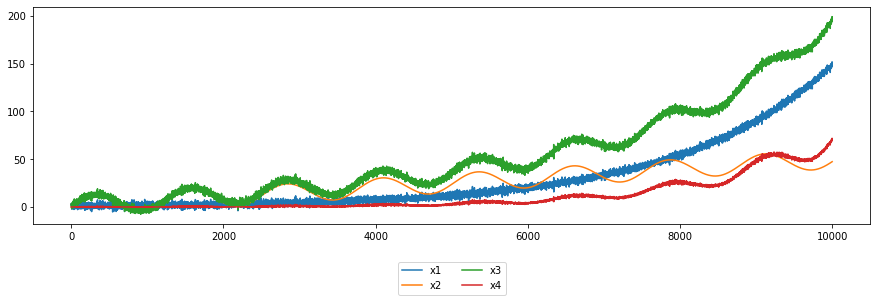

In [9]:
surrogate_samples = 10000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x3)), x3, label='x3')
plt.plot(range(len(x4)), x4, label='x4')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

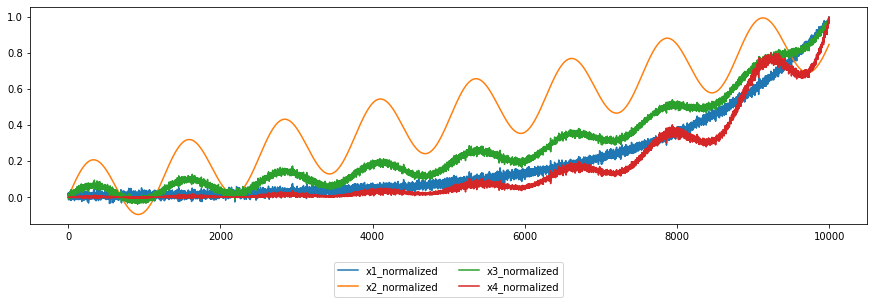

In [10]:
# normalize per time series
x1_normalized = x1 / np.ceil(np.max(np.abs(x1)))
x2_normalized = x2 / np.ceil(np.max(np.abs(x2)))
x3_normalized = x3 / np.ceil(np.max(np.abs(x3)))
x4_normalized = x4 / np.ceil(np.max(np.abs(x4)))


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()


In [11]:
surrogate_data = np.array([x1_normalized,x2_normalized,x3_normalized,x4_normalized]).T
print(surrogate_data.shape)
surrogate_truncated = create_rolling_windows(surrogate_data,200)
print(surrogate_truncated.shape)
#print(surrogate_truncated[0])


(10000, 4)
(9801, 200, 4)


In [12]:
# Override surrogate data with sth easier 
surrogate_data = np.array([x5,x5*0.2+0.4]).T
surrogate_truncated = create_rolling_windows(surrogate_data,200)
print(surrogate_truncated.shape)


(9801, 200, 2)


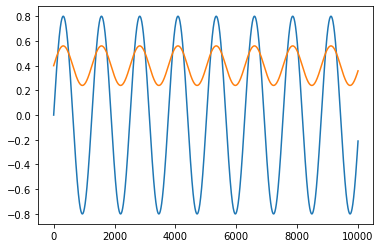

In [13]:
plt.plot(surrogate_data)

Total datapoints: 9801 For training: 7840 For testing: 1961


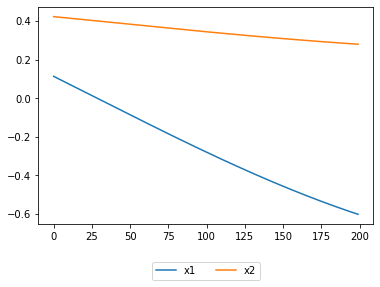

In [14]:
# Find max(abs(value))
#scaling_factor = np.ceil(np.max(np.abs(surrogate_truncated)))

# Train and test split 
train_test_ratio = 0.8
split_idx = int(len(surrogate_truncated) * train_test_ratio)
train_set = surrogate_truncated[:split_idx]
test_set = surrogate_truncated[split_idx:]
print("Total datapoints: " + str(len(surrogate_truncated)) + " For training: " + str(train_set.shape[0]) + " For testing: " + str(test_set.shape[0]))

plt.plot(range(len(train_set[600])), train_set[600], label=["x1",  "x2"]) #,  "x3",  "x4"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()


# Input and output split, apply scaling factor
train_set_source = train_set[:,:,:1] #/ scaling_factor
train_set_target = train_set[:,:,1:] #/ scaling_factor
test_set_source = test_set[:,:,:1] #/ scaling_factor
test_set_target = test_set[:,:,1:] #/ scaling_factor





## Model Class 

In [15]:
## TODO: Proper inheritance. Get rid of Model inheritance? Model compilation otherwise outside of class? 

In [16]:
class LSTMSeq2Seq_1(Model):
    
    def __init__(self, n_hidden, input_shape, output_shape):
        super(LSTMSeq2Seq_1, self).__init__()
        

        model_input = Input(shape = input_shape)
        model_output = Input(shape = output_shape)

        encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
         n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
         return_sequences=False, return_state=True)(model_input)

        encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
        encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

        decoder = RepeatVector(model_output.shape[1])(encoder_last_h1)
        decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
            decoder, initial_state=[encoder_last_h1, encoder_last_c])

        out = TimeDistributed(Dense(model_output.shape[2]))(decoder)

        self.model = Model(inputs=model_input, outputs=out)
        opt = Adam(lr=0.01, clipnorm=1)
        self.model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
        self.model.summary()

        plot_model(self.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


class LSTMSeq2Seq(Model):
    
    def __init__(self, n_hidden, input_shape, output_shape):
        super(LSTMSeq2Seq, self).__init__()

        
        # Define an input sequence and process it.
        encoder_inputs = Input(shape=(input_shape))
        encoder = LSTM(n_hidden, return_state=True)
        encoder_outputs, state_h, state_c = encoder(encoder_inputs)
        # We discard `encoder_outputs` and only keep the states.
        encoder_states = [state_h, state_c]

        # Set up the decoder, using `encoder_states` as initial state.
        decoder_inputs = Input(shape=(output_shape))
        # We set up our decoder to return full output sequences,
        # and to return internal states as well. We don't use the 
        # return states in the training model, but we will use them in inference.
        decoder_lstm = LSTM(n_hidden, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                             initial_state=encoder_states)
        decoder_dense = Dense(output_shape[0], activation='softmax')
        decoder_outputs = decoder_dense(decoder_outputs)

        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
        #opt = Adam(lr=0.01, clipnorm=1)
        self.model.compile(loss='mean_squared_error', metrics=['mae']) # optimizer=opt, 
        self.model.summary()
        
    
    def call(self, inputs):
        
        return self.model(inputs)
        
        
        
        pass


In [17]:
LSTM_model = LSTMSeq2Seq_1(100,(train_set_source.shape[1], train_set_source.shape[2]),(train_set_target.shape[1], train_set_target.shape[2]))



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 40800       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 200, 100)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
LSTM_model.model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
#LSTM_model.model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#          batch_size=batch_size,
#          epochs=epochs,
#          validation_split=0.2)

In [19]:
history = None
epc = 20
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = LSTM_model.model.fit(train_set_source, train_set_target, validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
LSTM_model.model.save('model_forecasting_seq2seq.h5')

Epoch 1/20
63/63 [==============================] - 38s 538ms/step - loss: 4.7565e-08 - val_loss: 5.0762e-08
Epoch 2/20
63/63 [==============================] - 35s 563ms/step - loss: 4.7773e-08 - val_loss: 5.0762e-08
Epoch 3/20
63/63 [==============================] - 33s 532ms/step - loss: 4.7827e-08 - val_loss: 5.0762e-08
Epoch 4/20
63/63 [==============================] - 33s 522ms/step - loss: 4.7686e-08 - val_loss: 5.0762e-08
Epoch 5/20
63/63 [==============================] - 33s 528ms/step - loss: 4.7618e-08 - val_loss: 5.0762e-08
Epoch 6/20
63/63 [==============================] - 33s 526ms/step - loss: 4.7779e-08 - val_loss: 5.0762e-08
Epoch 7/20
63/63 [==============================] - 34s 535ms/step - loss: 4.8067e-08 - val_loss: 5.0762e-08
Epoch 8/20
63/63 [==============================] - 35s 557ms/step - loss: 4.7725e-08 - val_loss: 5.0762e-08
Epoch 9/20
63/63 [==============================] - 36s 571ms/step - loss: 4.7733e-08 - val_loss: 5.0762e-08
Epoch 10/20
63/63 [

KeyError: 'mae'

In [20]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

NameError: name 'train_mae' is not defined

In [21]:

test_pred = LSTM_model.model.predict(test_set_source)
test_true = test_set_target


In [22]:
print(test_true)
print(test_pred)

[[[0.55965178]
  [0.55970254]
  [0.5597493 ]
  ...
  [0.49704439]
  [0.49640706]
  [0.49576733]]

 [[0.55970254]
  [0.5597493 ]
  [0.55979208]
  ...
  [0.49640706]
  [0.49576733]
  [0.4951252 ]]

 [[0.5597493 ]
  [0.55979208]
  [0.55983085]
  ...
  [0.49576733]
  [0.4951252 ]
  [0.49448069]]

 ...

 [[0.24715625]
  [0.24739477]
  [0.2476371 ]
  ...
  [0.35494043]
  [0.35570868]
  [0.35647805]]

 [[0.24739477]
  [0.2476371 ]
  [0.24788323]
  ...
  [0.35570868]
  [0.35647805]
  [0.3572485 ]]

 [[0.2476371 ]
  [0.24788323]
  [0.24813318]
  ...
  [0.35647805]
  [0.3572485 ]
  [0.35802002]]]
[[[ 0.15078789]
  [ 0.30371994]
  [ 0.40303487]
  ...
  [ 0.7739788 ]
  [ 0.77397895]
  [ 0.77397907]]

 [[ 0.1507692 ]
  [ 0.3027303 ]
  [ 0.40144733]
  ...
  [ 0.76764655]
  [ 0.76764655]
  [ 0.76764655]]

 [[ 0.15074041]
  [ 0.30172744]
  [ 0.3998456 ]
  ...
  [ 0.76139176]
  [ 0.76139176]
  [ 0.7613918 ]]

 ...

 [[-0.06828457]
  [-0.10850791]
  [-0.14510693]
  ...
  [-0.29873443]
  [-0.29873443]
  

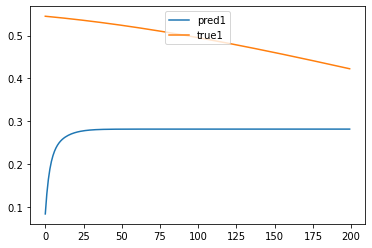

In [23]:
plt.plot(test_pred[100,:,0], label="pred1")
#plt.plot(test_pred[100,:,1], label="pred2")
plt.plot(test_true[100,:,0], label="true1")
#plt.plot(test_true[100,:,1], label="true2")
plt.legend(loc="upper center")
plt.show()

In [ ]:
print(1/0)

## Real data 

In [ ]:
# What the net should do 
# Input: HmdPosition & NoseVector
# Output: EyePosWorld & EyeDirWorldCombined

# Get truncated data 
truncated = measurement1.truncate_data(filtered_data, 200, method = "numpy")

# Available data:
# HmdPosition.x  HmdPosition.y  HmdPosition.z  NoseVector.x  NoseVector.y NoseVector.z  EyePosWorldCombined.x  EyePosWorldCombined.y EyePosWorldCombined.z  EyeDirWorldCombined.x  EyeDirWorldCombined.y  EyeDirWorldCombined.z  resampled_timestamp  is_interpolated  

# Drop last two columns of unneeded data 
truncated = np.delete(truncated,[12,13],axis=2)


In [ ]:
np.shape(truncated)

In [ ]:
# Find max(abs(value))
scaling_factor = np.ceil(np.max(np.abs(truncated)))

# Train and test split 
train_test_ratio = 0.8
split_idx = int(len(truncated) * train_test_ratio)
train_set = truncated[:split_idx]
test_set = truncated[split_idx:]
print("Total datapoints: " + str(len(truncated)) + " For training: " + str(train_set.shape[0]) + " For testing: " + str(test_set.shape[0]))

plt.plot(range(len(train_set[2])), train_set[2], label=["HmdPosition.x",  "HmdPosition.y",  "HmdPosition.z",  "NoseVector.x",  "NoseVector.y", "NoseVector.z",  "EyePosWorldCombined.x",  "EyePosWorldCombined.y", "EyePosWorldCombined.z",  "EyeDirWorldCombined.x",  "EyeDirWorldCombined.y",  "EyeDirWorldCombined.z"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()


# Input and output split, apply scaling factor
train_set_source = train_set[:,:,:6] / scaling_factor
train_set_target = train_set[:,:,6:] / scaling_factor
test_set_source = test_set[:,:,:6] / scaling_factor
test_set_target = test_set[:,:,6:] / scaling_factor




In [ ]:
print(1/0)

In [ ]:
# train and test data 
# format, full array with columns holding the data: 
# IN: HmdPosition.x, HmdPosition.y, HmdPosition.z, NoseVector.x, NoseVector.y, NoseVector.z
# OUT: EyeDirWorldCombined.x, EyeDirWorldCombined.y, EyeDirWorldCombined.z


#### HMDPosition is affected by moving car!
# "HmdPosition.x","HmdPosition.y","HmdPosition.z"
# Possibly detrend? Over all subjects? 


train_and_test_in = reduced_df[["NoseVector.x","NoseVector.y","NoseVector.z"]].to_numpy()
train_and_test_target = reduced_df[["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]].to_numpy()


In [ ]:
plt.plot(range(len(train_and_test_in)), train_and_test_in, label=["NoseVector.x","NoseVector.y","NoseVector.z"])
plt.plot(range(len(train_and_test_target)), train_and_test_target, label=["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
# Things todo 
# Possibly detrend
# Normalize (between -1 and 1), already the case. 

train_test_ratio = 0.8
split_idx_in = int(len(train_and_test_in) * train_test_ratio)
split_idx_target = int(len(train_and_test_target) * train_test_ratio)


In [ ]:
# Generate dataset 

train_in = train_and_test_in[0:split_idx_in]
test_in = train_and_test_in[split_idx_in:]
train_target = train_and_test_target[0:split_idx_target]
test_target = train_and_test_target[split_idx_target:]

print(train_and_test_in.shape)
print(train_in.shape, test_in.shape)
print(train_and_test_target.shape)
print(train_target.shape, test_target.shape)

In [ ]:
# Truncate dataset 

def truncate(data, window_size):
    result = []
    i = 0
    while (i + window_size) <= len(data):
        result.append(data[i:i+window_size])
        i += 1
    return np.array(result)


truncated_train_in = truncate(train_in,200) # use 200 data points for training input
truncated_train_target = truncate(train_target,200) # use same number (200) for training output, i.e. generated
truncated_test_in = truncate(test_in,200)
truncated_test_target = truncate(test_target,200)

print(truncated_train_in.shape)
print(truncated_train_target.shape)
print(truncated_test_in.shape)
print(truncated_test_target.shape)

In [ ]:
# Build DNN

n_hidden = 100

input_train = Input(shape=(truncated_train_in.shape[1], truncated_train_in.shape[2]))
output_train = Input(shape=(truncated_train_target.shape[1], truncated_train_target.shape[2]))
print(input_train)
print(output_train)


encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)




In [ ]:
#encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
#encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)


decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)


out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
history = None
epc = 2
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(truncated_train_in, truncated_train_target, validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

In [ ]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
# possibly detrend etc

In [ ]:
train_pred = model.predict(truncated_train_in)
test_pred = model.predict(truncated_test_in)
print(train_pred.shape, test_pred.shape)
train_true = truncated_train_target
test_true = truncated_test_target
print(train_true.shape, test_true.shape)

In [ ]:
train_pred = train_pred[~np.isnan(train_pred)]
train_true = train_true[~np.isnan(train_true)]
plt.figure(figsize=(15, 4))
plt.hist(train_pred.flatten(), bins=100, color='orange', alpha=0.5, label='trainpred')
plt.hist(train_true.flatten(), bins=100, color='green', alpha=0.5, label='traintrue')
plt.legend()
plt.title('value distribution: train')
plt.show()

print(train_pred)

In [ ]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

In [ ]:
# Calculate trend

x_index = np.array(range(len(t)))

x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)


x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
# Detrend

x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
# Combine sequences

x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

# Calculate maxs 
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

# Normalize 
x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:

def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)


X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

In [ ]:
n_hidden = 100

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)


encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)


In [ ]:



encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)


decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)


out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

In [ ]:

plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

In [ ]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

In [ ]:

data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

In [ ]:

for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

In [ ]:

for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

In [ ]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

In [ ]:

lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
'''
class ParticipantData:
    '''
    Class for data of an individual participant.
    (Data includes eyetracking, input, participantcalibrationdata and scenedata)
    '''
   
    def __init__(self, eyetracking_filepaths, input_filepaths, calibration_filepath, scenedata_filepaths, bootstrap_file_loading=False, verbose = False):
        '''
        Constructor.
        @ Paths to the relevant files 
        '''
        
        # sanity checks 
        # after this, we can be sure, that all paths exist, the files have labels corresponding to what they should contain
        # the participant id is always the same, the number of files per list corresponds and there is one calibration path 
        # the lists are lists of strings and the calibration data is a string 
        if (eyetracking_filepaths is None or input_filepaths is None or calibration_filepath is None or scenedata_filepaths is None):
            raise AssertionError("Some of the supplied paths are None! Exiting.")
        if (not isinstance(eyetracking_filepaths, list) or not isinstance(input_filepaths, list) or not isinstance(calibration_filepath, str) or not isinstance(scenedata_filepaths, list)):
            raise AssertionError("Some of the paths are not supplied in the correct format! Exiting.")
        if (len(eyetracking_filepaths) != len(input_filepaths) or len(eyetracking_filepaths) != len(scenedata_filepaths)):
            raise AssertionError("The number of supplied paths per category does not match! Exiting.")
        if (len(eyetracking_filepaths) < 1):
            raise AssertionError("Some supplied path lists have less than one element! Exiting.")
        if (not all(isinstance(elem,str) for elem in eyetracking_filepaths) or not all(isinstance(elem,str) for elem in input_filepaths) or not all(isinstance(elem,str) for elem in scenedata_filepaths)):
            raise AssertionError("The supplied path lists do not contain string contents! Exiting.")
        participant_id = "-8"
        for elem in eyetracking_filepaths + input_filepaths + [calibration_filepath] + scenedata_filepaths:
            if not os.path.isfile(elem):
                raise AssertionError("Some of the supplied paths do not link to existing files! Exiting.")
            try:
                if (participant_id == "-8"):
                    participant_id = os.path.basename(elem).split("_")[0]
                else:
                    next_participant_id = os.path.basename(elem).split("_")[0]
                    if next_participant_id != participant_id:
                        raise AssertionError("Some of the supplied paths do not link to files of the same participant! Exiting.")
                    else:
                        participant_id = next_participant_id 
            except:
                raise AssertionError("Some of the supplied paths do not link to files of the same participant! Exiting.")
        for elem in eyetracking_filepaths:
            if not "_EyeTracking_" in elem:
                raise AssertionError("Some of the supplied paths for eye tracking data link to files that are labeled for something else! Exiting.")
        for elem in input_filepaths:
            if not "_Input_" in elem:
                raise AssertionError("Some of the supplied paths for input data link to files that are labeled for something else! Exiting.")
        if not "_ParticipantCalibrationData" in calibration_filepath:
            raise AssertionError("The supplied path for participant calibration data links to a file that is labeled for something else! Exiting.")
        for elem in scenedata_filepaths:
            if not "_SceneData_" in elem:
                raise AssertionError("Some of the supplied paths for scene data link to files that are labeled for something else! Exiting.")
        
        
        # store filepaths
        self.eyetracking_filepaths = eyetracking_filepaths
        self.input_filepaths = input_filepaths
        self.calibration_filepath = calibration_filepath
        self.scenedata_filepaths = scenedata_filepaths
        
        # store participant id and number of recorded areas and verbosity and whether reference data has been applied
        self.participant_id = os.path.basename(eyetracking_filepaths[0]).split("_")[0]
        self.number_of_recorded_areas = len(eyetracking_filepaths)
        self.verbose = verbose
        self.reference_data_applied = False 
        
        # init data dictionaries 
        self.eyetracking_data = {}
        self.input_data = {}
        self.calibration_data = {}
        self.scene_data = {} 
        self.golden_segment_data = {}
        self.golden_event_info = {}
        
        # bootstrap file loading
        if bootstrap_file_loading and os.path.isfile(os.path.join(BOOTSTRAP_BASEPATH, "./bootstrap_" + str(self.participant_id) + ".pickle")):
            bootstrap_data = load_from_disk(os.path.join(BOOTSTRAP_BASEPATH, "./bootstrap_" + str(self.participant_id) + ".pickle"))
            self.participant_id = bootstrap_data["participant_id"]
            self.eyetracking_data = bootstrap_data["eyetracking_data"]
            self.input_data = bootstrap_data["input_data"]
            self.calibration_data = bootstrap_data["calibration_data"]
            self.scene_data = bootstrap_data["scene_data"]
            self.golden_segment_data = bootstrap_data["golden_segment_data"]
            self.golden_event_info = bootstrap_data["golden_event_info"] 
            print("ParticipantData: Loaded data (bootstrapped) for participant " + str(self.participant_id) + ".")
    
        else:
            # process raw data 
            self._load_raw_data()
            self._extract_event_information()
            self._extract_path_segments()
            self._resample_path_segments()  
            self._construct_segment_data()
            self._construct_event_info()
            print("ParticipantData: Loaded data (raw) for participant " + str(self.participant_id) + ".")
            
            # save to disk 
            if bootstrap_file_loading:
                bootstrap_data = {}
                bootstrap_data["participant_id"] = self.participant_id
                bootstrap_data["eyetracking_data"] = self.eyetracking_data
                bootstrap_data["input_data"] = self.input_data
                bootstrap_data["calibration_data"] = self.calibration_data
                bootstrap_data["scene_data"] = self.scene_data
                bootstrap_data["golden_segment_data"] = self.golden_segment_data
                bootstrap_data["golden_event_info"] = self.golden_event_info
                save_to_disk(bootstrap_data,os.path.join(BOOTSTRAP_BASEPATH, "./bootstrap_" + str(self.participant_id) + ".pickle"))

    
    def _read_raw_data(self, filepaths):
        '''
        Read raw files into dictionary. 
        '''
        
        data = {}
        
        for idx, filename in enumerate(filepaths):
            if self.verbose: 
                print("ParticipantData: Loading " + filename + " (file " + str(idx+1) + "/" + str(len(filepaths)) + ")...")
            
            if "Westbrueck" in filename:
                token = "Westbrueck"
            elif "MountainRoad" in filename:
                token = "MountainRoad"
            elif "CountryRoad" in filename:
                token = "CountryRoad"
            elif "Autobahn" in filename:
                token = "Autobahn"  
            elif "TrainingScene" in filename:
                token = "TrainingScene"
            else:  # not defined 
                print("ParticipantData: Found undefined area token in filename" + filename + "!")
                continue # in the loop     
            data[token] = {}
            data[token]["filename"] = filename
            data[token]["full_df"] = read_normalized_json_to_df(filename)
        
        return data 
    
    def _load_raw_data(self):
        
        # Eye tracking data
        if self.verbose: 
            print("ParticipantData: Loading raw eyetracking data files...")
        self.eyetracking_data = self._read_raw_data(self.eyetracking_filepaths)
        
        # Input data 
        if self.verbose: 
            print("ParticipantData: Loading raw input data files...")
        self.input_data = self._read_raw_data(self.input_filepaths)
        
        # Scene data  
        if self.verbose: 
            print("ParticipantData: Loading raw scene data files...")
        self.scene_data = self._read_raw_data(self.scenedata_filepaths)

        # Calibration data  
        if self.verbose:
            print("ParticipantData: Loading raw calibration data...")
        self.calibration_data = {}
        self.calibration_data['filename'] = self.calibration_filepath
        self.calibration_data['full_df'] = read_normalized_json_to_df(self.calibration_filepath)
        
        print("Calib")
        print(self.calibration_data)
        
        
    def _extract_event_information(self):
        
        # Extract most important event information 
        for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn","TrainingScene"]:
            self.scene_data[area]["number_of_events"] = len(self.scene_data[area]["full_df"]["EventBehavior"][0])
            self.scene_data[area]["events"] = {}
            for idx, event in enumerate(self.scene_data[area]["full_df"]["EventBehavior"][0]):
                self.scene_data[area]["events"][idx] = {'name':event["EventName"],'start':event["StartofEventTimeStamp"],'stop':event["EndOfEventTimeStamp"],'succeeded':event["SuccessfulCompletionState"]}
        
        print("Event info")
        print(self.scene_data)
        
    
    def _extract_path_segments(self):
        '''
        Extract the path segments. 
        Skip the TrainingScene, no relevant data. 
        '''
        
        
        # Copy of entire dataframe input dataframe to prepare processing
        for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
            self.input_data[area]["processed_df"] = self.input_data[area]["full_df"].copy(deep=True)
            self.input_data[area]["processed_df"].drop(columns=["ReceivedInput","SteeringInput","AcellerationInput","BrakeInput"],inplace=True)
            self.input_data[area]["processed_df"]["path_segment_label"] = -9 # event label 

        # Give label to individual path segments, -9 is event label 
        for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
            for event_idx in range(len(self.scene_data[area]["events"]) + 1):
                cond = None 
                if event_idx == 0: # find all datapoints with timestamps before event start timestamp 
                    cond = (self.input_data[area]["processed_df"]["TimeStamp"] < self.scene_data[area]["events"][event_idx]["start"])
                elif event_idx < len(self.scene_data[area]["events"]): # find all datapoints with timestamp between prev and next event 
                    cond = (self.input_data[area]["processed_df"]["TimeStamp"] > self.scene_data[area]["events"][event_idx - 1]["stop"]) & (self.input_data[area]["processed_df"]["TimeStamp"] < self.scene_data[area]["events"][event_idx]["start"])
                elif event_idx == len(self.scene_data[area]["events"]): # find all datapoints with timestamp after last event
                    cond = (self.input_data[area]["processed_df"]["TimeStamp"] > self.scene_data[area]["events"][event_idx - 1]["stop"])

                # Filter     
                self.input_data[area]["processed_df"].loc[cond, "path_segment_label"] = event_idx

        # Extract path segments, add timestamps beginning at zero 
        for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
            self.input_data[area]["path_segments_no_resample"] = {}
            for label in self.input_data[area]["processed_df"]["path_segment_label"].unique():
                if (label != -9):

                    # copy segment data 
                    cond = (self.input_data[area]["processed_df"]["path_segment_label"] == label)
                    self.input_data[area]["path_segments_no_resample"][label] = self.input_data[area]["processed_df"].loc[cond].copy(deep=True)

                    # add timestamp starting at zero 
                    if label == 0: # take first recorded datapoint as base timestamp 
                        ref_timestamp = self.input_data[area]["path_segments_no_resample"][label]["TimeStamp"].iloc[0]
                    else: # take last event's stop time as base timestamp 
                        ref_timestamp = self.scene_data[area]["events"][label - 1]["stop"]

                    self.input_data[area]["path_segments_no_resample"][label]["rebased_timestamp"] = self.input_data[area]["path_segments_no_resample"][label]["TimeStamp"] - ref_timestamp

                else: # skip events 
                    pass 
         
        print("path segment")
        print(self.input_data)
    
    
    def _resample_path_segments(self):
        '''
        Resample the path segments.
        Exclude TrainingScene, no relevant data. 
        '''
        

        if self.verbose:
            print("ParticipantData: Resampled path segments (excl. events):")
        for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:

            self.input_data[area]["path_segments_resampled"] = {}
            for segment in self.input_data[area]["path_segments_no_resample"]:
                # copy segments 
                self.input_data[area]["path_segments_resampled"][segment] = self.input_data[area]["path_segments_no_resample"][segment].copy(deep=True)

                # Hard match datapoints to closest timebin and fill arising holes by forward fill 
                if RESAMPLE_STRATEGY == "FILL":

                    # round the timestamps to specified number of decimals 
                    self.input_data[area]["path_segments_resampled"][segment]["rebased_timestamp_rounded"] = self.input_data[area]["path_segments_resampled"][segment]["rebased_timestamp"].round(TIMESTAMP_DECIMALS)

                    # "resample" timestamps by reindexing with time delta (default 0.01s) steps and filling holes; first drop duplicate timestamps
                    self.input_data[area]["path_segments_resampled"][segment]["resampled_timestamp"] = self.input_data[area]["path_segments_resampled"][segment]["rebased_timestamp_rounded"] 
                    self.input_data[area]["path_segments_resampled"][segment].drop_duplicates(subset="resampled_timestamp",keep="first", inplace=True)
                    start_time = 0
                    end_time = self.input_data[area]["path_segments_resampled"][segment]["resampled_timestamp"].iloc[-1]
                    time_delta = TIME_DELTA 
                    new_index = pd.Index(np.arange(start_time,end_time,time_delta), name="resampled_timestamp")
                    self.input_data[area]["path_segments_resampled"][segment] = self.input_data[area]["path_segments_resampled"][segment].set_index("resampled_timestamp").reindex(new_index).reset_index()

                    # keep track of where data was interpolated 
                    self.input_data[area]["path_segments_resampled"][segment]["is_interpolated"] = self.input_data[area]["path_segments_resampled"][segment]["rebased_timestamp"].isnull()

                    # fill nans ("interpolate") 
                    exclude_columns = ["rebased_timestamp","rebased_timestamp_rounded","is_interpolated","TimeStamp","resampled_timestamp"]
                    for column in self.input_data[area]["path_segments_resampled"][segment].columns:  
                        if column not in exclude_columns:
                            self.input_data[area]["path_segments_resampled"][segment][column].fillna(method='ffill', inplace = True)
                            self.input_data[area]["path_segments_resampled"][segment][column].fillna(method='bfill', inplace = True)

                    # drop unneeded columns
                    self.input_data[area]["path_segments_resampled"][segment].drop(columns=["TimeStamp","rebased_timestamp","rebased_timestamp_rounded","path_segment_label"], inplace = True)


                # Resample using pandas' resample, fill with mean 
                if RESAMPLE_STRATEGY == "MEAN":

                    # copy timestamp 
                    self.input_data[area]["path_segments_resampled"][segment]["resampled_timestamp"] = self.input_data[area]["path_segments_resampled"][segment]["rebased_timestamp"] 

                    # create datetime from rebased timestamp
                    self.input_data[area]["path_segments_resampled"][segment]["rebased_datetime"] = pd.to_datetime(self.input_data[area]["path_segments_resampled"][segment]['resampled_timestamp'],unit='s')

                    # resample with time delta (default 0.01s) interval and keep track of holes in the data before interpolation
                    self.input_data[area]["path_segments_resampled"][segment] = self.input_data[area]["path_segments_resampled"][segment].resample(str(TIME_DELTA) + 'S',on="rebased_datetime").mean()
                    self.input_data[area]["path_segments_resampled"][segment]["is_interpolated"] = self.input_data[area]["path_segments_resampled"][segment]["resampled_timestamp"].isnull()
                    self.input_data[area]["path_segments_resampled"][segment].reset_index(inplace=True)

                    # interpolate linearly
                    self.input_data[area]["path_segments_resampled"][segment].interpolate(method="linear",inplace=True)

                    # get resampled_timestamp from rebased_datetime again 
                    self.input_data[area]["path_segments_resampled"][segment]["resampled_timestamp"] = (self.input_data[area]["path_segments_resampled"][segment]["rebased_datetime"] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')

                    # drop unneeded columns
                    self.input_data[area]["path_segments_resampled"][segment].drop(columns=["rebased_datetime","TimeStamp","rebased_timestamp","path_segment_label"], inplace = True)

                if self.verbose:
                    print("Area: " + area + " Segment: " + str(segment) + " Total datapoints (incl. resampled): " + str(len(self.input_data[area]["path_segments_resampled"][segment]["is_interpolated"]))  + " Filled NaNs: " + str(self.input_data[area]["path_segments_resampled"][segment]["is_interpolated"].values.sum()))
        
        print("resample")
        print(self.input_data)
        

    def _construct_segment_data(self):
        
        # extract most important infos
        for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
            self.golden_segment_data[area] = {}
            for segment in self.input_data[area]["path_segments_resampled"]:
                self.golden_segment_data[area][segment] = self.input_data[area]["path_segments_resampled"][segment].copy(deep = True)
            
                
    def _construct_event_info(self):
    
        # extract event infos 
        for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
            self.golden_event_info[area] = {}
            for event in self.scene_data[area]["events"]:
                self.golden_event_info[area][event] = {}
                self.golden_event_info[area][event]['name'] = self.scene_data[area]["events"][event]['name']
                self.golden_event_info[area][event]['start'] = self.scene_data[area]["events"][event]['start']
                self.golden_event_info[area][event]['stop'] = self.scene_data[area]["events"][event]['stop']
                self.golden_event_info[area][event]['succeeded'] = self.scene_data[area]["events"][event]['succeeded']
    
    def apply_reference_data(self, ref_data_dict):
        
        for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
            for segment in self.golden_segment_data[area]:
                max_len = len(self.golden_segment_data[area][segment])
                if len(ref_data_dict[area][segment]) < max_len:
                    max_len = len(ref_data_dict[area][segment])
                if self.verbose:
                    print("ParticipantData: Measured df length is " + str(len(self.golden_segment_data[area][segment])) \
                        + ", reference df length is " + str(len(ref_data_dict[area][segment])) \
                        + ", max length is " + str(max_len))
                    
                # potentially cut length of data if reference data is shorter
                self.golden_segment_data[area][segment] = self.golden_segment_data[area][segment].iloc[0:max_len]
                
                # apply reference data values 
                print(self.golden_segment_data[area][segment].columns)
                print(ref_data_dict[area][segment].columns)
                    
                    
                #print(len(self.golden_segment_data[area][segment]))
                #print(reference_paths_all_events_failed["Westbrueck"][3].iloc[0:2422])
                
    def set_verbosity(self,verbosity):
        self.verbosity = verbosity 
                
    def get_segment_data(self):
        return self.golden_segment_data
    
    def get_event_info(self):
        return self.golden_event_info
    
    def get_participant_id(self):
        return self.participant_id 
        

'''

In [ ]:
# Old Stuff
'''

# TODO Resample to constant time bins for proper FFT 
# Use Lomb-Scargle Periodogram to compare to spectogram of resample data 


f = np.linspace(0.01, 1000, 1000000) # start, stop, number of pts; modify this! 
pgram = signal.lombscargle(reduced_df["UnixTimeStamp"], reduced_df["HmdPosition.x"], f) # f, normalize=True

plt.plot(f, pgram)
'''